In [1]:
from openrtdynamics2.dsp import *
import math
import numpy as np
import openrtdynamics2.lang, openrtdynamics2.dsp as dy
import openrtdynamics2.py_execute as dyexe
import openrtdynamics2.targets as tg
import os

import matplotlib.pyplot as plt
#%matplotlib widget 
# https://github.com/matplotlib/ipympl

from vehicle_lib.vehicle_lib import *

In [2]:
system = dy.enter_system()

velocity               = dy.system_input( dy.DataTypeFloat64(1), name='velocity',              default_value=5.0,    value_range=[0, 25],     title="vehicle velocity [m/s]")

s1                     = dy.system_input( dy.DataTypeFloat64(1), name='s1',                    default_value=0.0,    value_range=[-0.05, 0.05], title="steering rate 1 [rad/s]")
s2                     = dy.system_input( dy.DataTypeFloat64(1), name='s2',                    default_value=0.0,    value_range=[-0.05, 0.05], title="steering rate 2 [rad/s]")
s3                     = dy.system_input( dy.DataTypeFloat64(1), name='s3',                    default_value=0.0,    value_range=[-0.05, 0.05], title="steering rate 3 [rad/s]")
s4                     = dy.system_input( dy.DataTypeFloat64(1), name='s4',                    default_value=0.0,    value_range=[-0.05, 0.05], title="steering rate 4 [rad/s]")
s5                     = dy.system_input( dy.DataTypeFloat64(1), name='s5',                    default_value=0.0,    value_range=[-0.05, 0.05], title="steering rate 5 [rad/s]")

initial_steering       = dy.system_input( dy.DataTypeFloat64(1), name='initial_steering',      default_value=-0.0,   value_range=[-40, 40],   title="initial steering angle [degrees]")       * dy.float64(math.pi / 180.0)
initial_orientation    = dy.system_input( dy.DataTypeFloat64(1), name='initial_orientation',   default_value=0.0,    value_range=[-360, 360], title="initial orientation angle [degrees]")    * dy.float64(math.pi / 180.0)

# parameters
wheelbase = 3.0

# sampling time
Ts = 0.01


steering_rate = dy.float64(0)

cnt = dy.counter()

steering_rate = dy.conditional_overwrite(steering_rate, condition= cnt >= dy.int32(200), new_value=s1 )
steering_rate = dy.conditional_overwrite(steering_rate, condition= cnt >= dy.int32(400), new_value=s2 )
steering_rate = dy.conditional_overwrite(steering_rate, condition= cnt >= dy.int32(600), new_value=s3 )
steering_rate = dy.conditional_overwrite(steering_rate, condition= cnt >= dy.int32(800), new_value=s4 )
steering_rate = dy.conditional_overwrite(steering_rate, condition= cnt >= dy.int32(1000), new_value=s5 )




# linearly increasing steering angle
delta = dy.euler_integrator( steering_rate, Ts, initial_state=initial_steering )
delta = dy.saturate(u=delta, lower_limit=-math.pi/2.0, upper_limit=math.pi/2.0)

# the model of the vehicle
x, y, psi, x_dot, y_dot, psi_dot = discrete_time_bicycle_model(delta, velocity, Ts, wheelbase, psi0=initial_orientation)


#
# outputs: these are available for visualization in the html set-up
#

dy.append_output(x, 'x')
dy.append_output(y, 'y')
dy.append_output(psi, 'psi')
dy.append_output(delta, 'steering')

# generate code for Web Assembly (wasm), requires emcc (emscripten) to build
code_gen_results = dy.generate_code(template=tg.TargetCppWASM(), folder="generated/trajectory_generation", build=True)

#
dy.clear()


compiling system simulation (level 0)... 
Generated code will be written to generated/trajectory_generation .
writing file generated/trajectory_generation/simulation_manifest.json
writing file generated/trajectory_generation/main.cpp
Running compiler: emcc --bind -s MODULARIZE=1 -s EXPORT_NAME="ORTD_simulator" generated/trajectory_generation/main.cpp -O2 -s -o generated/trajectory_generation/main.js
Compilation result:  0


In [3]:
from IPython.display import JSON
JSON(code_gen_results['manifest'])

<IPython.core.display.JSON object>

In [4]:
compiled_system = dyexe.CompiledCode(code_gen_results)

In [5]:
testsim = dyexe.SystemInstance(compiled_system)

N=3000
input_data = {'initial_steering': 0.0, 's1' : 0.1, 's2' : -0.1 }

# sim_results = run_batch_simulation(testsim, input_data, N )
sim_results = dyexe.run_batch_simulation(testsim, input_data, N,  output_keys=['x', 'y', 'steering'] )

In [6]:
sim_results['y']

array([ 0.        ,  0.        ,  0.        , ..., 82.01190522,
       82.04273643, 82.07356764])

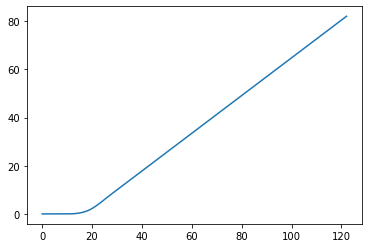

In [7]:
plt.figure()
plt.plot(sim_results['x'], sim_results['y'])
plt.show()



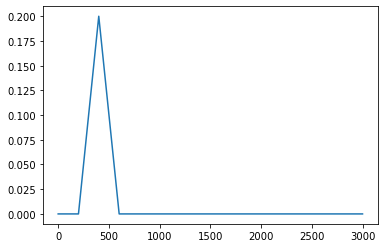

In [8]:
plt.figure()
plt.plot( sim_results['steering'])


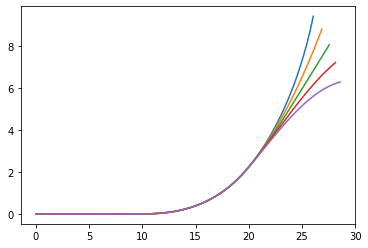

In [9]:
testsim = dyexe.SystemInstance(compiled_system)

N=600

plt.figure()

for s2 in np.linspace(-0.0,-0.2,5):
    
    input_data = {'initial_steering': 0.0, 's1' : 0.1, 's2' : s2 }

    sim_results = dyexe.run_batch_simulation(testsim, input_data, N,  output_keys=['x', 'y', 'steering'] )    
    plt.plot(sim_results['x'], sim_results['y'])
    


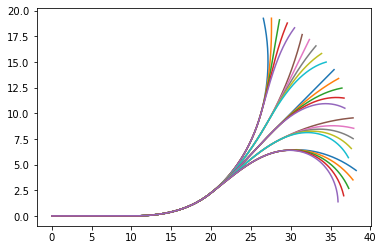

In [10]:
testsim = dyexe.SystemInstance(compiled_system)

N=600+200

plt.figure()

for s2 in np.linspace(-0.0,-0.2,5):
    for s3 in np.linspace(-0.0,-0.2,5):

        input_data = {'initial_steering': 0.0, 's1' : 0.1, 's2' : s2, 's3' : s3 }

        sim_results = dyexe.run_batch_simulation(testsim, input_data, N,  output_keys=['x', 'y', 'steering'] )
        plt.plot(sim_results['x'], sim_results['y'])

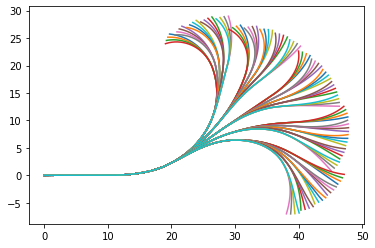

In [11]:
testsim = dyexe.SystemInstance(compiled_system)

N=600+200+200

plt.figure()

for s2 in np.linspace(-0.0,-0.2,5):
    for s3 in np.linspace(-0.0,-0.1,5):
        for s4 in np.linspace(0.1,+0.2,4):

            input_data = {'initial_steering': 0.0, 's1' : 0.1, 's2' : s2, 's3' : s3, 's4' : s4 }

            sim_results = dyexe.run_batch_simulation(testsim, input_data, N,  output_keys=['x', 'y', 'steering'] )
            plt.plot(sim_results['x'], sim_results['y'])

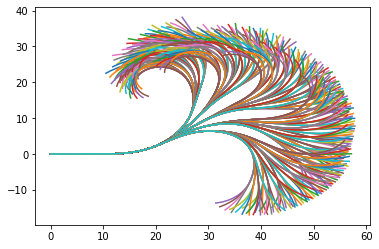

In [12]:
testsim = dyexe.SystemInstance(compiled_system)

N=600+200+200+200

plt.figure()

for s2 in np.linspace(-0.0,-0.2,5):
    for s3 in np.linspace(-0.0,-0.1,5):
        for s4 in np.linspace(0.1,+0.2,4):
            for s5 in np.linspace(-0.1,+0.1,4):

                input_data = {'initial_steering': 0.0, 's1' : 0.1, 's2' : s2, 's3' : s3, 's4' : s4, 's5' : s5 }

                sim_results = dyexe.run_batch_simulation(testsim, input_data, N,  output_keys=['x', 'y', 'steering'] )
                plt.plot(sim_results['x'], sim_results['y'])